In [36]:
import matplotlib.pyplot as plt
import numpy as np
import time
from numba import njit, prange, cuda
from system import *
from tqdm import tqdm

In [52]:
def laplacian2(X):
    Xn = X.copy()
    Xn[1:-1,1:-1] = X[1:-1,2:] + X[1:-1,0:-2] + X[2:,1:-1] + X[0:-2,1:-1] - 4*X[1:-1,1:-1]
    
    Xn[0,1:-1] = X[1,1:-1] + X[-1,1:-1] + X[0,2:] + X[0,0:-2] - 4*X[0,1:-1]
    Xn[-1,1:-1] = X[0,1:-1] + X[-2,1:-1] + X[-1,2:] + X[-1,0:-2] - 4*X[-1,1:-1]
    Xn[1:-1,0] = X[1:-1,1] + X[1:-1,-1] + X[2:,0] + X[0:-2,0] - 4*X[1:-1,0]
    Xn[1:-1,-1] = X[1:-1,0] + X[1:-1,-2] + X[2:, -1] + X[0:-2, -1] - 4*X[1:-1,-1]
    
    Xn[0,0] = X[1,0] + X[-1,0] + X[0,1] + X[0,-1] - 4*X[0,0]
    Xn[0,-1] = X[1,-1] + X[-1,-1] + X[0,0] + X[0,-2] - 4*X[0,-1]
    Xn[-1,0] = X[0,0] + X[-2,0] + X[-1,1] + X[-1,-1] - 4*X[-1,0]
    Xn[-1,-1] = X[0,-1] + X[-2,-1] + X[-1,0] + X[-1,-2] - 4*X[-1,-1]
    return Xn

def laplacian(X):
    return np.roll(X,1,axis = 0) + np.roll(X,-1,axis = 0) + np.roll(X,1,axis = 1) + np.roll(X,-1,axis = 1) - 4*X

def cpu_solver(S,I,beta,gamma=.2,D=1,tstep=.01,t_max = 1000):
    for _ in range(t_max):
        S = S + tstep*(-beta*S*I)
        I = I + tstep*(beta*S*I - gamma*I + D*laplacian(I))
        S[:,0] = S[:,-1] = I[:,0] = I[:,-1] = 0
    return S,I

@njit()
def cpu_numba_solver(S,I,beta,gamma=.2,D=1,tstep=.01,t_max = 1000):
    Ly,Lx = S.shape
    S = S.reshape(Ly*Lx)
    I = I.reshape(Ly*Lx)
    fS = np.zeros_like(S)
    fI = np.zeros_like(I)
    for _ in range(t_max):
        for i in range(Lx*Ly):
            x = i % Lx
            y = i // Lx
            fS[i] = -beta*S[i]*I[i]
            fI[i] = beta*S[i]*I[i] - gamma*I[i] + D*(I[(x+1)%Lx + Lx*y] + I[(x-1+Lx)%Lx+Lx*y] + I[x + Lx*((y+1)%Ly)] + I[x + Lx*((y-1+Ly)%Ly)] - 4*I[i])
        S = S + tstep*fS
        I = I + tstep*fI
        S[::Lx] = S[Lx-1::Lx] = I[::Lx] = I[Lx-1::Lx] = 0
    return S.reshape(Ly,Lx),I.reshape(Ly,Lx)

@njit(parallel=True)
def cpup_numba_solver(S,I,beta,gamma=.2,D=1,tstep=.01,t_max = 1000):
    Ly,Lx = S.shape
    S = S.reshape(Ly*Lx)
    I = I.reshape(Ly*Lx)
    fS = np.zeros_like(S)
    fI = np.zeros_like(I)
    for _ in range(t_max):
        for i in prange(Lx*Ly):
            x = i % Lx
            y = i // Lx
            fS[i] = -beta*S[i]*I[i]
            fI[i] = beta*S[i]*I[i] - gamma*I[i] + D*(I[(x+1)%Lx + Lx*y] + I[(x-1+Lx)%Lx+Lx*y] + I[x + Lx*((y+1)%Ly)] + I[x + Lx*((y-1+Ly)%Ly)] - 4*I[i])
        S = S + tstep*fS
        I = I + tstep*fI
        S[::Lx] = S[Lx-1::Lx] = I[::Lx] = I[Lx-1::Lx] = 0
    return S.reshape(Ly,Lx),I.reshape(Ly,Lx)


In [30]:
#Compilar funciones
L = 1024
S = np.ones((L,L))
I = np.zeros((L,L))
S[:,1] = np.zeros_like(S[:,1])
I[:,1] = np.ones_like(I[:,1])
c = cpu_solver(S,I,beta=1,t_max=1000)[1]
L = 1024
S = np.ones((L,L))
I = np.zeros((L,L))
S[:,1] = np.zeros_like(S[:,1])
I[:,1] = np.ones_like(I[:,1])
a = cpu_numba_solver(S,I,beta=1,t_max=1000)[1]
S = np.ones((L,L))
I = np.zeros((L,L))
S[:,1] = np.zeros_like(S[:,1])
I[:,1] = np.ones_like(I[:,1])
b = cpup_numba_solver(S,I,beta=1,t_max=1000)[1]

In [12]:
n = np.arange(100,1500,20)
gpu_time = np.array([])
t_max = 1000

for N in tqdm(n):
    s = System(N)
    s.gamma = .2
    s.D = 1
    s.beta = 1
    s.dt = .01
    s.set_plane_initial_conditions()
    t0 = time.time()
    s.solve(t_max)
    cuda.synchronize()
    tf = time.time()
    gpu_time = np.append(gpu_time,tf-t0)
np.save('gpu_time',gpu_time)
np.save('N',n)

100%|██████████| 70/70 [00:29<00:00,  2.35it/s]


In [11]:
n = np.arange(100,1500,20)
cpu_time = np.array([])
N_vec = np.array([])
beta = 1
for N in tqdm(n):
    S = np.ones((N,N))
    I = np.zeros((N,N))
    S[:,1] = np.zeros_like(S[:,1])
    I[:,1] = np.ones_like(I[:,1])
    s = time.time()
    cpu_solver(S,I,beta,t_max=1000)
    e = time.time()
    cpu_time = np.append(cpu_time,e-s)
np.save('cpu_time',cpu_time)

100%|██████████| 70/70 [35:26<00:00, 30.38s/it]


In [40]:
n = np.arange(100,1500,20)
cpu_numba_time = np.array([])
N_vec = np.array([])
for N in tqdm(n):
    beta = 1
    S = np.ones((N,N))
    I = np.zeros((N,N))
    S[:,1] = np.zeros_like(S[:,1])
    I[:,1] = np.ones_like(I[:,1])
    s = time.time()
    cpu_numba_solver(S,I,beta,t_max=1000)
    e = time.time()
    cpu_numba_time = np.append(cpu_numba_time,e-s)
np.save('cpu_numba_time',cpu_numba_time)

100%|██████████| 70/70 [12:59<00:00, 11.14s/it]


In [37]:
n = np.arange(100,1500,20)
cpup_numba_time = np.array([])
N_vec = np.array([])
for N in tqdm(n):
    beta = 1
    S = np.ones((N,N))
    I = np.zeros((N,N))
    S[:,1] = np.zeros_like(S[:,1])
    I[:,1] = np.ones_like(I[:,1])
    s = time.time()
    cpup_numba_solver(S,I,beta,t_max=1000)
    e = time.time()
    cpup_numba_time = np.append(cpup_numba_time,e-s)
np.save('cpup_numba_time',cpup_numba_time)

100%|██████████| 70/70 [04:38<00:00,  3.98s/it]


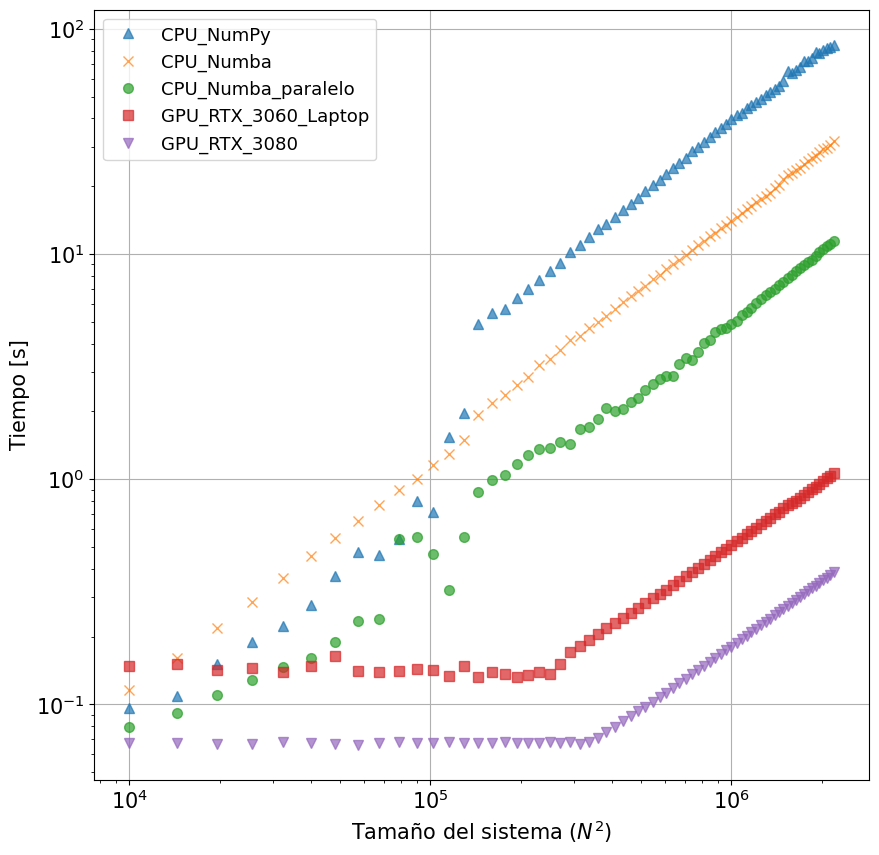

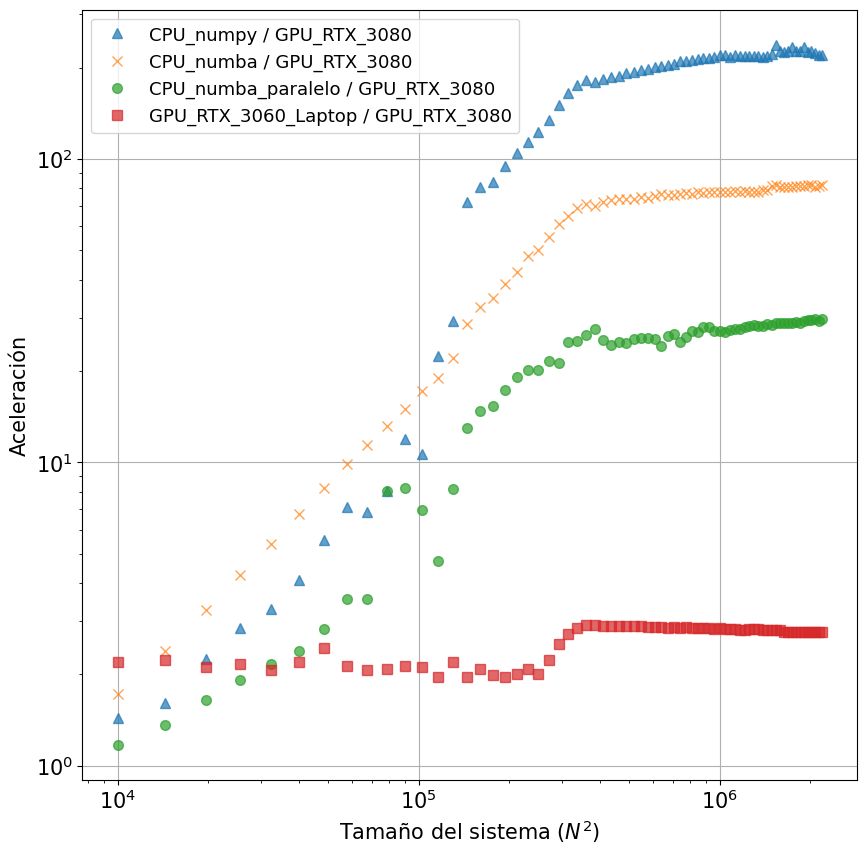

In [45]:
gpu_time = np.load('gpu_time.npy')
gpu_time_cluster = np.load('gpu_time_cluster.npy')
cpu_time = np.load('cpu_time.npy')
cpu_numba_time = np.load('cpu_numba_time.npy')
cpup_numba_time = np.load('cpup_numba_time.npy')
n = np.load('N.npy')
delta1 = cpu_time - gpu_time
delta2 = cpu_numba_time - gpu_time
delta3 = cpup_numba_time - gpu_time
ratio1 = cpu_time/gpu_time
ratio2 = cpu_numba_time/gpu_time
ratio3 = cpup_numba_time/gpu_time
ratio1_c = cpu_time/gpu_time_cluster
ratio2_c = cpu_numba_time/gpu_time_cluster
ratio3_c = cpup_numba_time/gpu_time_cluster
ratio4_c = gpu_time/gpu_time_cluster 


fig,ax = plt.subplots(figsize=(10,10))
ax.loglog(n*n,cpu_time,'^',label='CPU_NumPy',alpha=.7,markersize=7)
ax.loglog(n*n,cpu_numba_time,'x',label='CPU_Numba',alpha=.7,markersize=7)
ax.loglog(n*n,cpup_numba_time,'o',label='CPU_Numba_paralelo',alpha=.7,markersize=7)
ax.loglog(n*n,gpu_time,'s',label='GPU_RTX_3060_Laptop',alpha=.7,markersize=7)
ax.loglog(n*n,gpu_time_cluster,'v',label='GPU_RTX_3080',alpha=.7,markersize=7)
ax.set_xlabel(r'Tamaño del sistema $(N^2)$',fontsize=15)
ax.set_ylabel('Tiempo [s]',fontsize=15)
plt.legend(loc=2,fontsize=13)
plt.grid()

#ticks size
ax.tick_params(axis='both', which='major', labelsize=15)
ax.tick_params(axis='both', which='minor', labelsize=15)


fig2 = plt.figure(figsize=(10,10))
#plt.loglog(n*n,ratio1,'^',label='CPU_numpy / GPU',alpha=.7,markersize=7)
#plt.loglog(n*n,ratio2,'x',label='CPU_numba / GPU',alpha=.7,markersize=7)
#plt.loglog(n*n,ratio3,'o',label='CPU_numba_paralelo / GPU',alpha=.7,markersize=7)
plt.loglog(n*n,ratio1_c,'^',label='CPU_numpy / GPU_RTX_3080',alpha=.7,markersize=7)
plt.loglog(n*n,ratio2_c,'x',label='CPU_numba / GPU_RTX_3080',alpha=.7,markersize=7)
plt.loglog(n*n,ratio3_c,'o',label='CPU_numba_paralelo / GPU_RTX_3080',alpha=.7,markersize=7)
plt.loglog(n*n,ratio4_c,'s',label='GPU_RTX_3060_Laptop / GPU_RTX_3080',alpha=.7,markersize=7)
plt.xlabel(r'Tamaño del sistema $(N^2)$',fontsize=15)
plt.ylabel('Aceleración',fontsize=15)
plt.legend(loc=2,fontsize=13)
plt.grid()

plt.xticks(fontsize=15)
plt.yticks(fontsize=15)

plt.show()



fig.savefig('/home/renzo/Tesis_M/tesis/Tesis_Tex/figs/cap3/cpuvsgpu.pdf',bbox_inches='tight')
fig2.savefig('/home/renzo/Tesis_M/tesis/Tesis_Tex/figs/cap3/cpuvsgpu_ratio.pdf',bbox_inches='tight')

#1230MHz